In [1]:
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.wcs import wcs
from astropy.coordinates import SkyCoord

In [3]:
from scipy.interpolate import Rbf

# Initialize data directory

In [4]:
path = "../../Data/Subaru_data/"

# Dust data

```
!open $path
```

In [5]:
dust = fits.open(path + "p358Dust.fits")

In [6]:
w = wcs.WCS(dust[0].header)

In [7]:
dust[0].header

SIMPLE  =                    T                                                  
BITPIX  =                  -64                                                  
NAXIS   =                    2                                                  
NAXIS1  =                   82                                                  
NAXIS2  =                   82                                                  
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BUNIT   = 'mag E(B-V)'                                                          
CTYPE1  = 'RA---TAN'                                                            
CTYPE2  = 'DEC--TAN'                                                            
CRVAL1  =           273.000000                                                  
CRVAL2  =            40.0000

In [8]:
pix_coords = np.array([[i, j] for i in range(dust[0].data.shape[0])
              for j in range(dust[0].data.shape[1])])

In [9]:
wcs_coords = w.wcs_pix2world(pix_coords, 1)

In [51]:
wcs_x = np.array(wcs_coords.transpose()[0])
wcs_y = np.array(wcs_coords.transpose()[1])

In [11]:
dust[0].data.shape

(82, 82)

In [12]:
wcs_x_grid = wcs_x.reshape((dust[0].data.shape[0], dust[0].data.shape[1]))
wcs_y_grid = wcs_y.reshape((dust[0].data.shape[0], dust[0].data.shape[1]))

# basic dust properties

In [13]:
np.mean(dust[0].data.ravel())

0.036121546490218627

In [14]:
np.std(dust[0].data.ravel())

0.0085454334243817032

## convert pixel to WCS so we can apply correction to data catalog

<matplotlib.colorbar.Colorbar instance at 0x112db3128>

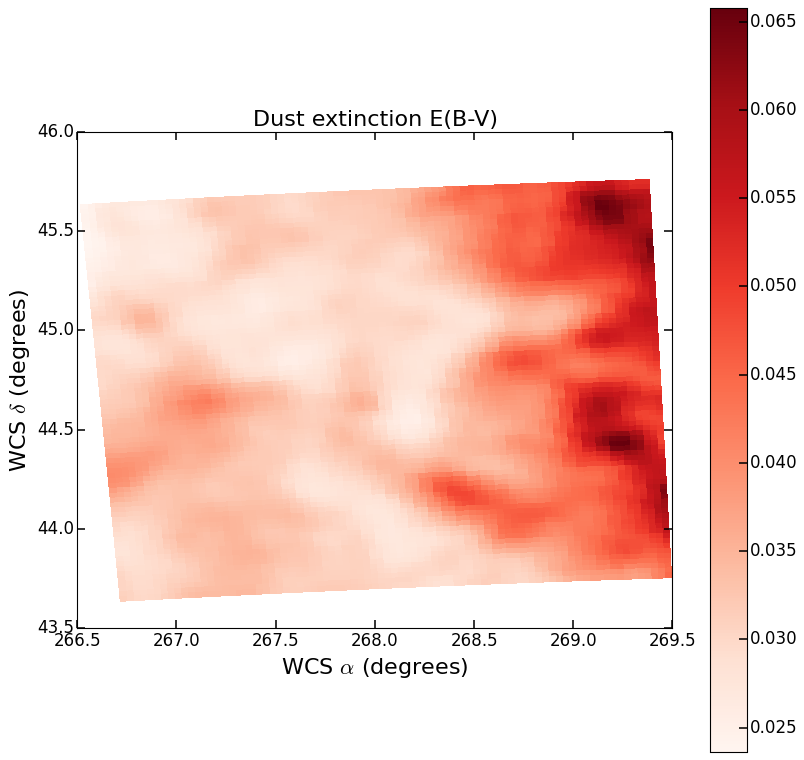

In [18]:
plt.figure(figsize=(12, 12))
plt.axes().set_aspect("equal")
plt.pcolor(wcs_x_grid, wcs_y_grid, dust[0].data.transpose(), 
           cmap=plt.cm.Reds)
plt.title("Dust extinction E(B-V)", size=20)
plt.ylabel(r"WCS $\delta$ (degrees)", size=20)
plt.xlabel(r"WCS $\alpha$ (degrees)", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.colorbar()



* checked the features of the above image with DS9
* ready to do dust extinction correction

\begin{equation}
E(B-V) \equiv A_B - A_V = (B-V)_{observed} - (B-V)_{intrinsic}
\end{equation}

Therefore, to correct for dust extinction in the (B-V) band, we have ...

\begin{equation}
(B-V)_{intrinsic} = (B - V)_{observed} - E(B-V)
\end{equation}

for each WCS pixel ... easy enough!
Reference: [http://en.wikipedia.org/wiki/Extinction_(astronomy)]('http://en.wikipedia.org/wiki/Extinction_(astronomy)')

### examine how the dust map compared to the coordinates in the shape catalog

In [19]:
shape_h5file = "../../Data/Subaru_data/combined_cat.h5"
shape_df_key = "preprocess_df"


In [20]:
Rshapes = pd.read_hdf(shape_h5file, shape_df_key)

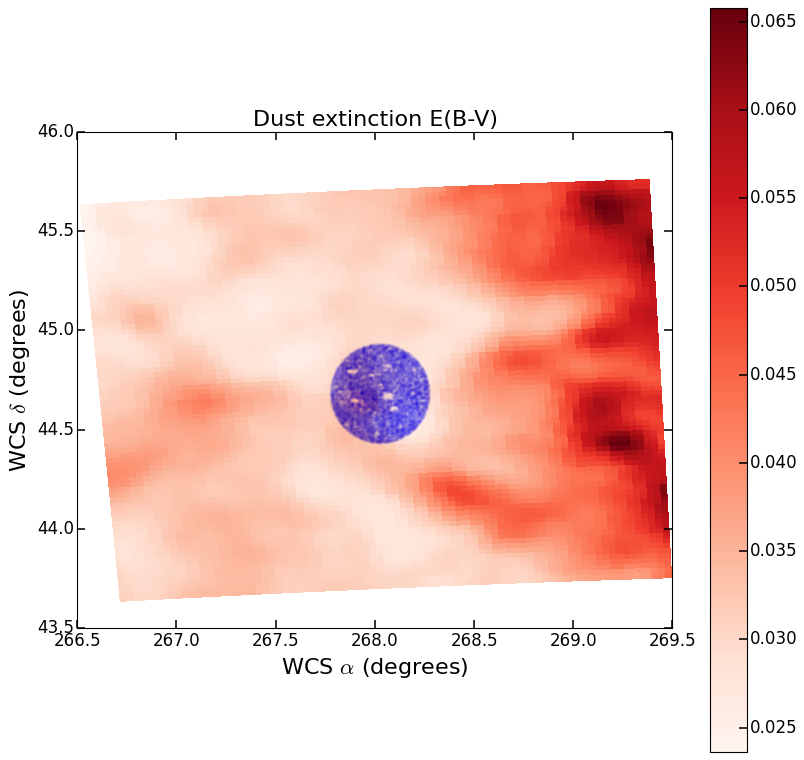

In [21]:

plt.figure(figsize=(12, 12))
plt.axes().set_aspect("equal")
plt.pcolor(wcs_x_grid, wcs_y_grid, dust[0].data.transpose(), 
           cmap=plt.cm.Reds)
plt.title("Dust extinction E(B-V)", size=20)
plt.ylabel(r"WCS $\delta$ (degrees)", size=20)
plt.xlabel(r"WCS $\alpha$ (degrees)", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.colorbar()

plt.plot(Rshapes.RA, Rshapes.DEC, '.', alpha=0.01)

# do interpolation

so our transformed dust data is actually diagonal so there are no longer just 81 x 81 grid in wcs coordinates... it's better for us to switch every thing to pixel coordinates then do interpolation

In [22]:
Rshapes_pix_coords = \
    w.wcs_world2pix(np.array([Rshapes.RA, Rshapes.DEC]).transpose(), 1)

In [23]:
XX, YY = np.meshgrid(range(dust[0].data.shape[0]),
                     range(dust[0].data.shape[0]))

The following two cells take quite some time to run

In [24]:
rbf = Rbf(XX, YY, dust[0].data, epsilon=2)

In [25]:
dust_ext = rbf(list(Rshapes_pix_coords.transpose()[0]),
               list(Rshapes_pix_coords.transpose()[1]))

In [26]:
dust_ext.shape

(42735,)

<matplotlib.colorbar.Colorbar instance at 0x10f2b29e0>

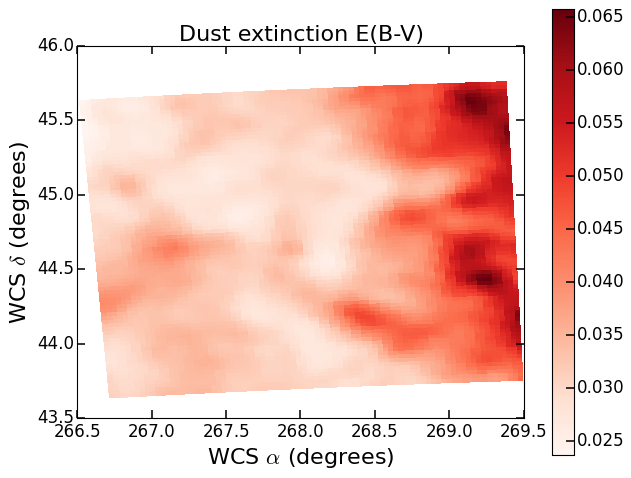

In [27]:
plt.axes().set_aspect("equal")


plt.pcolor(wcs_x_grid, wcs_y_grid, dust[0].data.transpose(), 
           cmap=plt.cm.Reds)

plt.title("Dust extinction E(B-V)", size=20)
plt.ylabel(r"WCS $\delta$ (degrees)", size=20)
plt.xlabel(r"WCS $\alpha$ (degrees)", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.colorbar()plt.pcolor(wcs_x_grid, wcs_y_grid, dust[0].data.transpose(), 
           cmap=plt.cm.Reds)

In [29]:
Rshapes["E(B-V)"] = dust_ext

# stop being lazy and just cut out relevant region

# verifying that I did the interpolation correctly

recalculate where to cut ... ref: van Weeren 2012 Fig. 1

In [ ]:
lower_left = SkyCoord("17h52m40s", "44d35m30s")
upper_right = SkyCoord("17h51m40s", "44d45m30s")
ra_upper = lower_left.ra.deg
ra_lower = upper_right.ra.deg
dec_lower = lower_left.dec.deg
dec_upper = upper_right.dec.deg

print ra_lower, ra_upper
print dec_lower, dec_upper

ra_mask = np.logical_and(wcs_x < ra_upper + 0.1,
                         wcs_x > ra_lower - 0.1)
dec_mask = np.logical_and(wcs_y < dec_upper + 0.1,
                          wcs_y > dec_lower - 0.1)
mask = np.logical_and(ra_mask, dec_mask)

In [32]:
ix = np.arange(len(wcs_x))[mask]

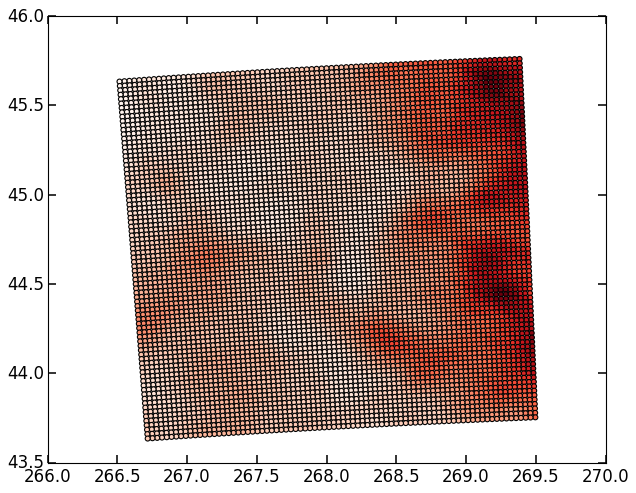

In [70]:
# the orientation of the dust map values were checked against 
# DS9 view of the dust map
plt.scatter(wcs_x, wcs_y, c=dust[0].data.transpose().ravel(),
            cmap=plt.cm.Reds)

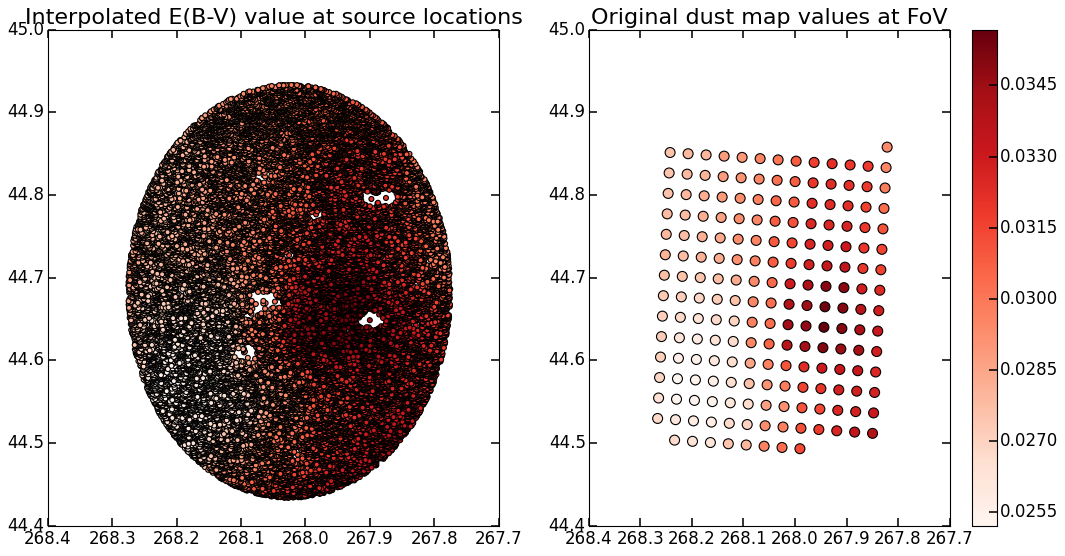

In [68]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Interpolated E(B-V) value at source locations")
plt.scatter(Rshapes.RA, Rshapes.DEC, c=dust_ext,
            cmap=plt.cm.Reds)
xlim = plt.xlim(plt.xlim()[::-1])
ylim = plt.ylim()
xticks, _ = plt.xticks()
_ = plt.xticks(xticks, [str(t) for t in xticks])
plt.subplot(122)
#plt.pcolor(wcs_x_grid, wcs_y_grid, dust[0].data.transpose(), 
#           cmap=plt.cm.Reds)
plt.title("Original dust map values at FoV")
plt.scatter(wcs_x[ix], wcs_y[ix], 
            c=dust[0].data.transpose().ravel()[ix],
            cmap=plt.cm.Reds, s=80)
plt.colorbar()
plt.ylim(ylim)
plt.xlim(xlim)
_ = plt.xticks(xticks, [str(t) for t in xticks])

# do actual correction

In [35]:
from preprocess_data import Schlafly_dereddening

In [36]:
for k in ["I", "G", "R"]:
    for bandtype in ["ISO", "AUTO", "APER"]:
        key = "{0}band_MAG_{1}".format(k, bandtype)
        Rshapes[key] = \
            Rshapes.apply(lambda x: Schlafly_dereddening(x[key], 
                                   x["E(B-V)"], 
                                   band_name="{}".format(k.lower())), 
                                   axis=1)

In [37]:
keys = ["{}band_MAG_ISO".format(k) for k in ["I", "G", "R"]]

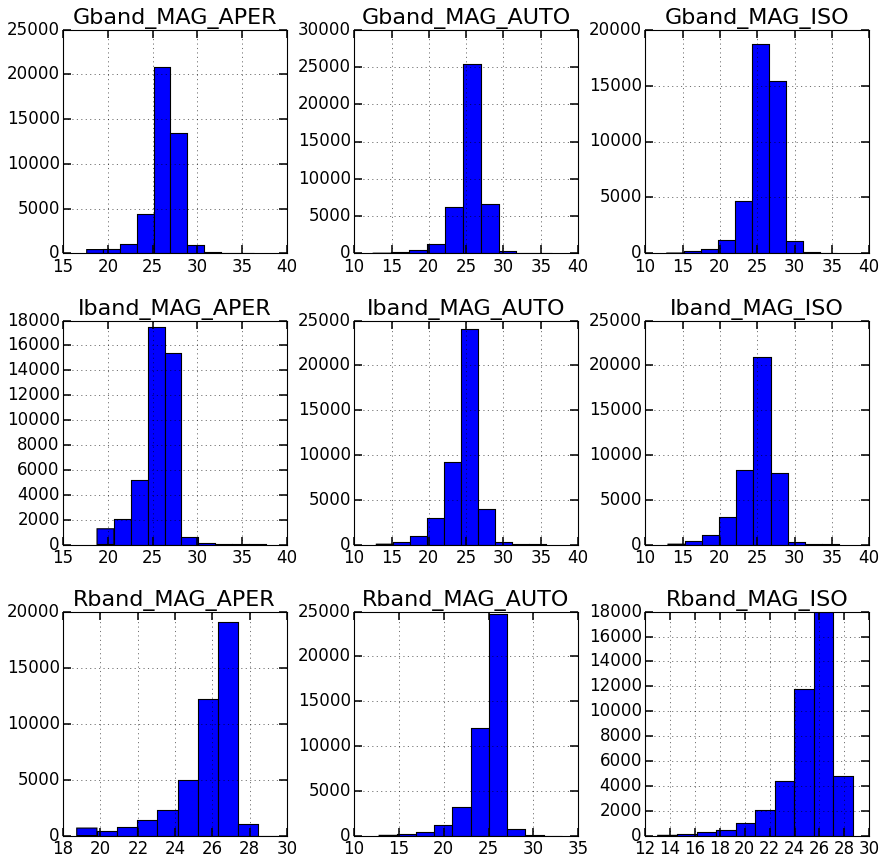

In [38]:
bands = [k for k in Rshapes.keys() if "_MAG_" in k]
_ = Rshapes[bands].hist(figsize=(13, 13))

In [39]:
Rshapes[bands].describe()

,Rband_MAG_ISO,Rband_MAG_APER,Rband_MAG_AUTO,Iband_MAG_ISO,Iband_MAG_APER,Iband_MAG_AUTO,Gband_MAG_ISO,Gband_MAG_APER,Gband_MAG_AUTO
count,42735.000000,42733.000000,42582.000000,42154.000000,42095.000000,41836.000000,41846.000000,41841.000000,40623.000000
mean,25.230026,25.739986,24.923391,25.056645,25.512452,24.669828,25.891937,26.311878,25.554816
std,1.980071,1.615623,1.816456,2.222886,1.840497,2.028832,2.009608,1.701371,1.876822
min,13.004297,18.728808,12.784573,13.043600,18.783519,12.964162,12.871689,17.632743,12.529636
25%,24.461068,25.256232,24.314446,24.063496,24.833061,23.850487,25.013689,25.709412,24.825405
50%,25.686193,26.215923,25.378112,25.502526,25.976894,25.095843,26.164924,26.583016,25.820337
75%,26.593032,26.821145,26.121143,26.557214,26.682346,25.962421,27.143383,27.245482,26.626719
max,28.691216,29.539686,33.194248,35.955148,37.646082,35.700815,35.696868,36.308224,36.549161


In [40]:
Rshapes.to_hdf(shape_h5file, shape_df_key)